In [27]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
import xgboost as xgb
import ast
import shap
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_percentage_error


In [28]:
shap.initjs() 

In [29]:
def evaluate_predictions(model, dataset_type, y_pred, y_truth):
    rmse = np.round(np.sqrt(mean_squared_error(y_truth, y_pred)), 0)
    mae = np.round(median_absolute_error(y_truth, y_pred), 0)
    mape = np.round(mean_absolute_percentage_error(y_truth, y_pred), 4)
    return {'model': [model], 'dataset_type': [dataset_type], 'rmse':[rmse], 'mae': [mae], 'mape':[mape]}

In [30]:
train_X, test_X = pd.read_csv("datasets/xgboost/train_X.csv", index_col=0),\
                  pd.read_csv("datasets/xgboost/test_X.csv", index_col=0)
train_y, test_y = pd.read_csv("datasets/xgboost/train_y.csv", index_col=0),\
                  pd.read_csv("datasets/xgboost/test_y.csv", index_col=0)

In [54]:
len(train_y)

932

In [31]:
len(test_y)

117

In [32]:
model_list = glob.glob('models/*.model')

In [33]:
model_list

['models/best_balanced_model_230.model',
 'models/best_mae_model_912.model',
 'models/best_mae_model_829.model',
 'models/second_best_model_1.model',
 'models/best_rmse_model_1245.model']

In [34]:
booster = xgb.XGBRegressor(objective = 'reg:squarederror', nthread=4, random_state=1992)
booster.load_model(model_list[3])

[17:40:27] WARNING: ../src/learner.cc:851: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Loading a native XGBoost model with Scikit-Learn interface.


In [55]:
train_y_pred = booster.predict(train_X)
print(evaluate_predictions('xgboost', 'test', train_y, train_y_pred))

{'model': ['xgboost'], 'dataset_type': ['test'], 'rmse': [2368776.0], 'mae': [1244431.0], 'mape': [0.3459]}


In [35]:
test_y_pred = booster.predict(test_X)
print(evaluate_predictions('xgboost', 'test', test_y, test_y_pred))

{'model': ['xgboost'], 'dataset_type': ['test'], 'rmse': [3687992.0], 'mae': [1089502.0], 'mape': [0.4711]}


In [36]:
test_eval = test_y
test_eval['y_pred'] = test_y_pred

In [37]:
test_eval['diffe'] = test_eval.y_pred - test_eval.mean_salary 
test_eval['perc_diff'] = np.round(test_eval.diffe/test_eval.mean_salary, 4)

### Dead money

Cuando un equipo se deshace de un jugador malo tiene que pagar una penalidad. Puede que quede el dato mal cargado

https://hoopshype.com/gallery/nba-dead-money-rankings-dion-waiters-joakim-noah/

1. Dion Waiters 503,656
2. Nicolas Batum 2,564,753 
3. Joakim Noah 1,491,397
4. DeMarre Carroll (sin equipo?)
5. Ryan Anderson
6. Luol Deng

<AxesSubplot:xlabel='y_pred', ylabel='diffe'>

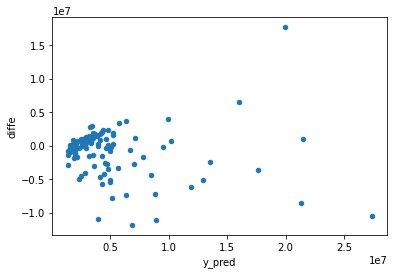

In [38]:
test_eval.plot.scatter(x='y_pred', y='diffe')

<AxesSubplot:ylabel='Frequency'>

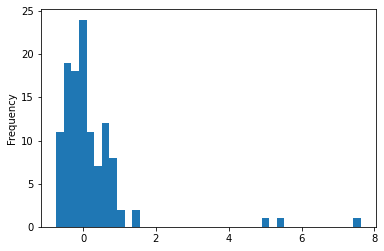

In [39]:
test_eval.perc_diff.plot.hist(bins=40)

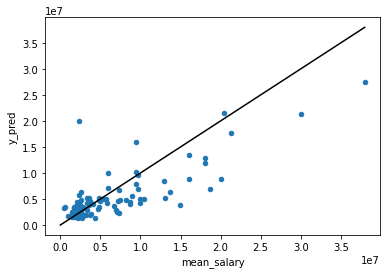

In [40]:
test_eval.plot.scatter(x="mean_salary", y='y_pred')
plt.plot([0,max(test_eval.mean_salary)], [0,max(test_eval.mean_salary)], c='black')

In [41]:
test_eval.sort_values('mean_salary')

,mean_salary,y_pred,diffe,perc_diff
player,,,,
Dion Waiters,503656.0,3287606.00,2783950.00,5.5275
Dewayne Dedmon,580811.0,3444643.50,2863832.50,4.9307
Quinn Cook,1000000.0,1822779.25,822779.25,0.8228
Zylan Cheatham,1445697.0,2125606.00,679909.00,0.4703
J.R. Smith,1456666.5,1576937.50,120271.00,0.0826
...,...,...,...,...
Jerami Grant,20000000.0,8916932.00,-11083068.00,-0.5542
Danilo Gallinari,20475000.0,21463326.00,988326.00,0.0483
Fred VanVleet,21250000.0,17626810.00,-3623190.00,-0.1705


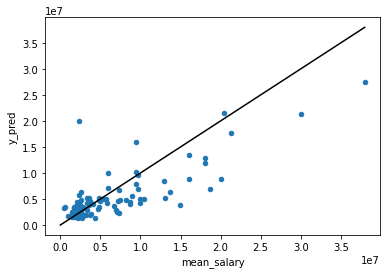

In [42]:
test_eval.plot.scatter(x="mean_salary", y='y_pred')
plt.plot([0,max(test_eval.mean_salary)], [0,max(test_eval.mean_salary)], c='black')

In [43]:
train_y_pred = booster.predict(train_X)

In [44]:
test_y_pred = booster.predict(test_X)

In [45]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(train_X)

In [46]:
explainer = shap.Explainer(booster)
shap_values = explainer(pd.DataFrame(train_X))

In [47]:
shap.plots.force(shap_values[0])

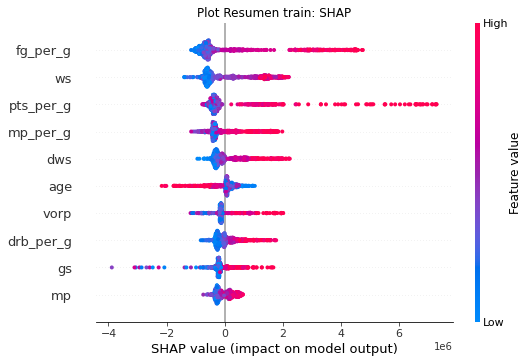

In [52]:
shap.summary_plot(shap_values, show=False, max_display=10)
plt.title("Plot Resumen train: SHAP")
plt.savefig("images/train_summary_plot_xgboost_mae.png")

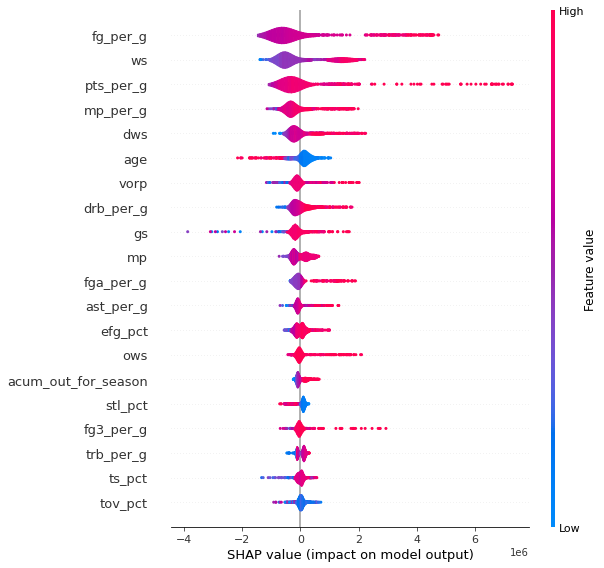

In [49]:
shap.summary_plot(shap_values, plot_type='violin')

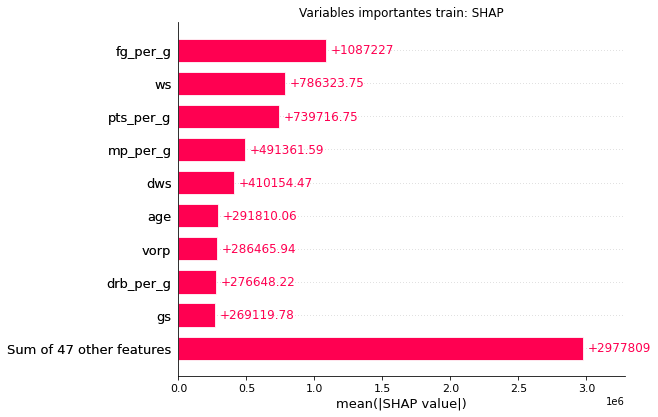

In [51]:
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title("Variables importantes train: SHAP")
plt.savefig("images/train_feature_importance_plot_xgboost_mae.png")

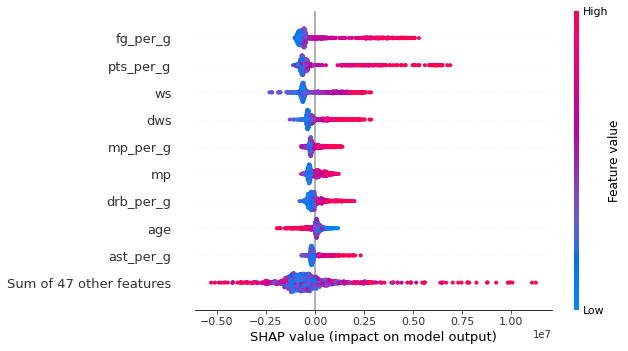

In [30]:
shap.plots.beeswarm(shap_values)